In [1]:
!git clone https://github.com/MansaGroup/kanedama.git
!pip install -r ./kanedama/datascience/requirements.txt && pip install tensorflow

Cloning into 'kanedama'...
remote: Enumerating objects: 991, done.
remote: Counting objects: 100% (608/608), done.
remote: Compressing objects: 100% (392/392), done.
remote: Total 991 (delta 389), reused 337 (delta 212), pack-reused 383
Receiving objects: 100% (991/991), 4.91 MiB | 15.32 MiB/s, done.
Resolving deltas: 100% (524/524), done.
     |████████████████████████████████| 51 kB 707 kB/s 
     |████████████████████████████████| 10.1 MB 7.8 MB/s 
     |████████████████████████████████| 54 kB 4.6 MB/s 
     |████████████████████████████████| 156 kB 89.9 MB/s 
     |████████████████████████████████| 61 kB 375 kB/s 
     |████████████████████████████████| 78 kB 10.3 MB/s 
     |████████████████████████████████| 54 kB 4.5 MB/s 
     |████████████████████████████████| 843 kB 60.0 MB/s 


In [2]:
from platform import python_version
print(python_version())

3.7.12


In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pylab as plt 

pd.options.mode.chained_assignment = None

path = './kanedama/datascience/data'

acc = pd.read_csv(path + '/accounts.csv')
transac = pd.read_csv(path + '/transactions.csv')

df = transac.merge(acc, left_on='account_id', right_on='id')
#Not clear if duplicates are real ones. We may need transaction id for exemple 
#to assess duplicity. I decided to keep duplicated row.
#dup = df.duplicated(subset=None, keep='first')
#df = df[~dup]
print(len(df))
print('Total of Nans:', sum(sum(df.isna().values)))

#cast dates to pd.date_time
df.date = pd.to_datetime(df.date)
df.update_date = pd.to_datetime(df.update_date)

#unique update date for everyone
assert len(np.unique(df.update_date)) == 1
end_date = np.unique(df.update_date)[0]

518229
Total of Nans: 0


In [4]:
df.head()

,account_id,date,amount,id,balance,update_date
0,0,2020-10-16,200.0,0,13.63,2021-07-02
1,0,2020-10-16,-192.0,0,13.63,2021-07-02
2,0,2020-10-16,200.0,0,13.63,2021-07-02
3,0,2020-10-16,-24.0,0,13.63,2021-07-02
4,0,2020-10-16,-50.0,0,13.63,2021-07-02


**Train test split**

I choose to leverage the relatively small sample buy using rolling windows along the history of each account. That is, we take a 180 days of history to predict the next 30 days outgoing value, i.e [T-180 : T[ ==> [T : T+30[.

We keep the last 30 days as test period, with no overlap between train and test, to avoid lookahead bias. In addition we take the same test period (last 30 days before the balance date) to avoid biais between possibly correlated samples : say A and B are correlated somehow, but A has a long history until the 2021-07-02, B has an history until the 2021-04-02. The test period of B would be in the train period of A. In case of correlation, this could lead to a biais. With no further informations on the dataset, let's not take that risk.

One pro of this approach is to artificially augment data sample number, however one clear cons is that we can't measure a model's performance on out-of-sample accounts. This is particularly problematic if we want to control for cold-start cases, where we encouter new accounts with no more than 180 days of history. We leave this issue for future improvements (and more datas). 

With this in mind, we choose to keep samples with at leat 240 days of history (180 + 30 for train, +30 for test period) and at least one transaction in the last 30 days before the update date.



Text(0.5, 1.0, 'History length distribution')

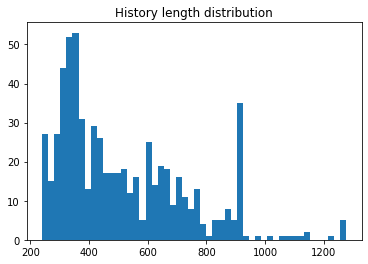

In [9]:
def cut(df)->list:
    """get list of df per account id"""
    all_ids = []
    for id in df.id.unique():
        df_ = df[df.id==id]
        all_ids.append(df_)
    return all_ids
    
all_ids = cut(df)

days = [(e.date.iloc[-1]-e.date.iloc[0]).days for e in all_ids]

#check validity of samples per id + remove sparse historical data (let's say < 50 transactions)
all_ids = [e for e in all_ids if (end_date-e.date.iloc[0]).days>=240 and 
           (end_date-e.date.iloc[-1]).days < 30 and 
           len(e)>50]

plt.hist([(end_date-e.date.iloc[0]).days for e in all_ids],50)
plt.title('History length distribution')

# **Features**

**Timestamp**

A first possible feature is a timestamp. However, we could not give it to the model as it is. One possible way to transform date values is cosine and sine transform, to leverage the periodicity of the year. A linear transform would be problematic here, as we want the end of the year to be very close of the start of the year. 

The nature of the data suggest a certain kind of periodicity (regular invoices, etc). Here we choose to underline the periodicity of the year as a default value, however one could improve this transform by choosing another period (e.g. month). This is left as future improvement.

**Running balance**

We use the final balance to recover the running balance during the year.

**Amounts**

We take the total amount per day, we create a column with positive amounts and one with negative amounts.

**Format**

We group all values per day (sum for amounts). This transform allows to process samples with fixed size, to "sum-up" the financial signals and reduce noise. This is a basic transform, to keep it simple. 

**However, it is not clear which level of granularity should be used here. Another possible way would be to leave the time series as they are (with padding if we need fixed size samples). This method could be used with neural network by assuming the unstructured side of the data. One more way would be to use a feature extraction library as [TsFresh](https://tsfresh.readthedocs.io/en/latest/) which extract statistical and structured features, that could be used by trees models for example. This process might be a good choice, even if this is not the chosen path here.**



In [10]:
def preprocess(df)->list:
  """ take a list of dataframes and return train 
      & test samples with computed features"""
  x = []
  y = []
  xt, yt = [], []

  for sample in df:
    starting_balance = sample.balance.iloc[0]-sample.amount.sum()
    sample['running_balance'] = starting_balance + sample.amount.cumsum()
    #take complete date range from start to end of a sample.
    date_range = pd.DataFrame(pd.date_range(sample.date.iloc[0], 
                                            end_date)).set_index(0)
    
    sample.set_index(sample.date, inplace=True)
    #join date_range with sample so that we have all days
    #missing days in the sample will be filled with NaNs
    sample = date_range.join(sample)
    
    #compute year timestamps
    timestamp_s = sample.index.map(pd.Timestamp.timestamp)
    day = 24*60*60
    year = (365.2425)*day
    sample['Year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    sample['Year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    #fill NaN running_balance with previous value
    sample['running_balance'].fillna(method='ffill', inplace=True)
    #fill NaN amount with 0 
    sample['amount'].fillna(0, inplace=True)
    #compute & group-by positive and negative amounts
    amounts_pos = sample.copy(deep=True)
    amounts_neg = sample.copy(deep=True)
    amounts_pos.amount[amounts_pos.amount<0] = 0
    amounts_neg.amount[amounts_neg.amount>0] = 0
    amounts_pos = amounts_pos.groupby(amounts_pos.index).sum().amount
    amounts_neg = amounts_neg.groupby(amounts_neg.index).sum().amount
    amounts = sample.groupby(sample.index).sum().amount
    #for each day, group-by and take last value (valid for all columns except amount, amount_pos and amount_neg)
    sample = sample.groupby(sample.index).last()
    #replace amounts columns by grouped & summed values
    sample['amount'] = amounts
    sample['amount_pos'] = amounts_pos
    sample['amount_neg'] = amounts_neg

    #train/test split with rolling windows (step of 5 days)
    for i in range(30*6, len(sample)-60, 5):
        x.append(sample.iloc[i-180:i])
        y.append(sample.iloc[i:i+30])
    #take last month as a test period
    xt.append(sample.iloc[i-180+30:i+30])
    yt.append(sample.iloc[i+30:i+60])
    
    #sanity check 
    assert all([len(e)==180 for e in x])
    assert all([len(e)==180 for e in xt])
    assert all([len(e)==30 for e in y])
    assert all([len(e)==30 for e in yt])

  return x, y, xt, yt

x, y, xt, yt = preprocess(all_ids)

In [11]:
x[0].head()

,account_id,date,amount,id,balance,update_date,running_balance,Year_sin,Year_cos,amount_pos,amount_neg
2020-10-16,0.0,2020-10-16,3086.00,0.0,13.63,2021-07-02,3101.84,-0.967141,0.254241,3400.0,-314.00
2020-10-17,0.0,2020-10-17,-3079.50,0.0,13.63,2021-07-02,22.34,-0.962624,0.270840,0.0,-3079.50
2020-10-18,0.0,2020-10-18,0.00,0.0,13.63,2021-07-02,22.34,-0.957823,0.287359,0.0,0.00
2020-10-19,0.0,2020-10-19,46.79,0.0,13.63,2021-07-02,69.13,-0.952738,0.303793,100.0,-53.21
2020-10-20,NaN,NaT,0.00,NaN,NaN,NaT,69.13,-0.947371,0.320137,0.0,0.00


In [12]:
#we take our usefull features
x_ = [e[['Year_sin', 'Year_cos', 'amount', 'running_balance', 'amount_pos', 'amount_neg']] for e in x]
y_ = [e[['amount_neg']] for e in y]
x_t = [e[['Year_sin', 'Year_cos', 'amount', 'running_balance', 'amount_pos', 'amount_neg']] for e in xt]
y_t = [e[['amount_neg']] for e in yt]

In [13]:
x_[1].head()

,Year_sin,Year_cos,amount,running_balance,amount_pos,amount_neg
2020-10-21,-0.941724,0.336386,-17.41,51.72,0.0,-17.41
2020-10-22,-0.935798,0.352536,0.00,51.72,0.0,0.00
2020-10-23,-0.929595,0.368582,482.50,534.22,707.0,-224.50
2020-10-24,-0.923118,0.384518,-22.00,512.22,0.0,-22.00
2020-10-25,-0.916367,0.400340,-115.75,396.47,0.0,-115.75


In [14]:
#we rename and cast list of dataframes to numpy arrays for convenience and speed (dimensions ==> (samples, timesteps, features))
X_train_, X_test_, y_train_, y_test_ = np.array(x_), np.array(x_t), np.array(y_), np.array(y_t)

In [15]:
print(x_t[0].columns)
#we keep track of columns indexes
AMOUNT_COL = x_t[0].columns.get_loc("amount")
BAL_COL = x_t[0].columns.get_loc("running_balance")
AMOUNT_POS_COL = x_t[0].columns.get_loc("amount_pos")
AMOUNT_NEG_COL = x_t[0].columns.get_loc("amount_neg")

Index(['Year_sin', 'Year_cos', 'amount', 'running_balance', 'amount_pos',
       'amount_neg'],
      dtype='object')


**Preprocessing features**

As we choose here to use a neural network based model, we should preprocess numerical features for a stabilized and faster training. 

**Amount**

Total amount per day could be negative of positive. It is natural to rescale this value by a standardization. We choose to remove extreme values by a simple rule (> or < mean +- 4*std). Test values are rescaled using train statistics.

-7.719692290361408 666.4167866140283 -5611.383115035036 5613.770325384254


Text(0.5, 1.0, 'Standardized amounts histogram')

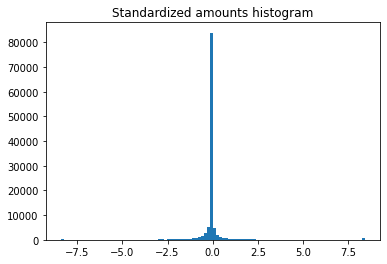

In [16]:
#TOTAL AMOUNTS PROCESSING
total_amount = [[x for x in e.amount.values] for e in x_]
total_amount = np.concatenate(total_amount)

#remove outliers
total_amount = np.clip(total_amount, np.mean(total_amount)-4*np.std(total_amount),
                           np.mean(total_amount)+4*np.std(total_amount))

#get stats
MEAN_AMOUNT = np.mean(total_amount)
STD_AMOUNT = np.std(total_amount)

#Keep stats for inference api
print(MEAN_AMOUNT, STD_AMOUNT, np.min(total_amount), np.max(total_amount))

def normalize_amount(x):
    x = np.clip(x, np.min(total_amount), np.max(total_amount))
    return ((x-MEAN_AMOUNT)/STD_AMOUNT)

X_train_[:,:,AMOUNT_COL] = normalize_amount(X_train_[:,:,AMOUNT_COL])
X_test_[:,:,AMOUNT_COL] = normalize_amount(X_test_[:,:,AMOUNT_COL])

_ = plt.hist(X_test_[:,:,AMOUNT_COL].reshape(-1,), 100)
plt.title('Standardized amounts histogram')

**Positive  and negative amounts**

Positive and negative amounts are log-normal distributed. We therefore apply a log transform to obtain normal distributed data. This allows to follow an additive and symmetric scale (and reduces scale). We choose to keep the value 0 as a special case, as it has a meaning here.

After log transform and standardization (for the same reason as above), we shift the distributions (by their min) to keep 0 as the lowest possible values.

Text(0.5, 1.0, 'Log transformed positive amounts')

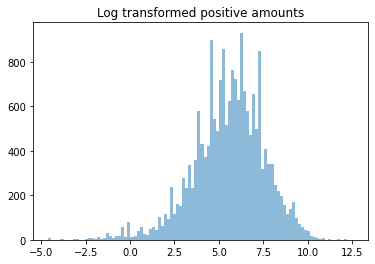

In [17]:
total_amount_pos = [[x for x in e.amount_pos.values if x > 0] for e in x_t]
total_amount_pos = np.concatenate(total_amount_pos)
_ = plt.hist(np.log(total_amount_pos.reshape(-1,)), 100, alpha=0.5, label='x')
plt.title('Log transformed positive amounts')

5.347356690940917 1.9899508215999484 -4.012087214365754 -2.6364995576168626 13.021652037560614


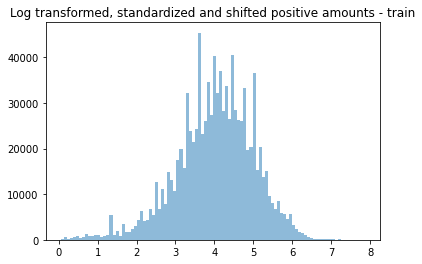

In [18]:
#POSITIVE AMOUNTS PROCESSING
total_amount_pos = [[x for x in e.amount_pos.values if x > 0] for e in x_]
total_amount_pos = np.concatenate(total_amount_pos)
#log transform
total_amount_pos = np.log(total_amount_pos)
#remove outliers
total_amount_pos = np.clip(total_amount_pos, np.mean(total_amount_pos)-4*np.std(total_amount_pos),
                           np.mean(total_amount_pos)+4*np.std(total_amount_pos))

#get statistics
MEAN_AMOUNT_POS = np.mean(total_amount_pos)
STD_AMOUNT_POS = np.std(total_amount_pos)
transformed_pos = ((total_amount_pos)-MEAN_AMOUNT_POS)/STD_AMOUNT_POS
MIN_AMOUNT_POS = np.min(transformed_pos)

#track stats for inference api
print(MEAN_AMOUNT_POS, STD_AMOUNT_POS, MIN_AMOUNT_POS, np.min(total_amount_pos), np.max(total_amount_pos))

def normalize_amount_pos(x):
    x = np.log(x)
    x = np.clip(x, np.min(total_amount_pos), np.max(total_amount_pos))
    return ((x-MEAN_AMOUNT_POS)/STD_AMOUNT_POS)-MIN_AMOUNT_POS

#process train and test values
a = X_train_[:,:,AMOUNT_POS_COL]
idx_ = np.where(a!=0)
a[idx_]= normalize_amount_pos(a[idx_])
X_train_[:,:,AMOUNT_COL] = a

a = X_test_[:,:,AMOUNT_POS_COL]
idx_ = np.where(a!=0)
a[idx_]= normalize_amount_pos(a[idx_])
X_test_[:,:,AMOUNT_POS_COL] = a

plot_values = X_train_[:,:,AMOUNT_POS_COL]
plot_values = plot_values[plot_values>0]
plt.hist(plot_values.reshape(-1,), 100, alpha=0.5, label='x')
plt.title('Log transformed, standardized and shifted positive amounts - train')
plt.show()

4.386852976026014 1.8165732026281949 -4.009683112954072 -2.8970299179971537 11.66890882011515


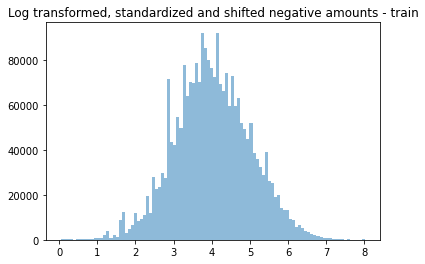

In [19]:
#PREPROCESS NEGATIVE AMOUNTS
total_amount_neg = [[x for x in e.amount_neg.values if x < 0] for e in x_]
total_amount_neg = -np.concatenate(total_amount_neg)

#log transform
total_amount_neg = np.log(total_amount_neg)
#remove outliers
total_amount_neg = np.clip(total_amount_neg, np.mean(total_amount_neg)-4*np.std(total_amount_neg),
                           np.mean(total_amount_neg)+4*np.std(total_amount_neg))

#get statistics
MEAN_AMOUNT_NEG = np.mean(total_amount_neg)
STD_AMOUNT_NEG = np.std(total_amount_neg)
transfor_neg = ((total_amount_neg)-MEAN_AMOUNT_NEG)/STD_AMOUNT_NEG
MIN_AMOUNT_NEG = np.min(transfor_neg)

print(MEAN_AMOUNT_NEG, STD_AMOUNT_NEG, MIN_AMOUNT_NEG, np.min(total_amount_neg), np.max(total_amount_neg))

def normalize_amount_neg(x):
    x = np.log(-x)
    x = np.clip(x, np.min(total_amount_neg), np.max(total_amount_neg))
    return ((x-MEAN_AMOUNT_NEG)/STD_AMOUNT_NEG)-MIN_AMOUNT_NEG

#preprocess train and test values
a = X_train_[:,:,AMOUNT_NEG_COL]
idx_ = np.where(a!=0)
a[idx_]= normalize_amount_neg(a[idx_])
X_train_[:,:,AMOUNT_NEG_COL] = a

a = X_test_[:,:,AMOUNT_NEG_COL]
idx_ = np.where(a!=0)
a[idx_]= normalize_amount_neg(a[idx_])
X_test_[:,:,AMOUNT_NEG_COL] = a

plot_values = X_train_[:,:,AMOUNT_NEG_COL]
plot_values = plot_values[plot_values>0]
plt.hist(plot_values.reshape(-1,), 100, alpha=0.5, label='x')
plt.title('Log transformed, standardized and shifted negative amounts - train')
plt.show()

**Balance**

The case of balance is trickier as a we could not obtain better shaped distribution as previous features. More complexe transformation as power transform (box-cox) didn't worked so well either. We end up by applying only a standardization.

2706.542538999867 7781.311982603436 -41299.90674364914 47316.41503818177


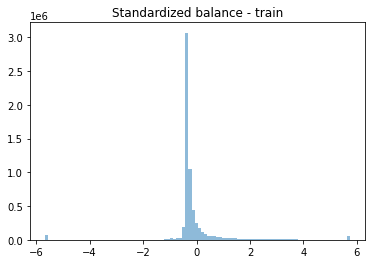

In [20]:
#COMPUTE STATS BALANCE PER DAY
r_balance = [[x for x in e.running_balance.values] for e in x_t]
r_balance = np.concatenate(r_balance)
r_balance = np.clip(r_balance, np.mean(r_balance)-4*np.std(r_balance),
                           np.mean(r_balance)+4*np.std(r_balance))

MEAN_AMOUNT_BAL = np.mean(r_balance)
STD_AMOUNT_BAL = np.std(r_balance)

print(MEAN_AMOUNT_BAL, STD_AMOUNT_BAL, np.min(r_balance), np.max(r_balance))

def normalize_bal(x):
    x = np.clip(x, np.min(r_balance), np.max(r_balance))
    return ((x-MEAN_AMOUNT_BAL)/STD_AMOUNT_BAL)

X_train_[:,:,BAL_COL] = normalize_bal(X_train_[:,:,BAL_COL])
X_test_[:,:,BAL_COL] = normalize_bal(X_test_[:,:,BAL_COL])


plot_values = X_train_[:,:,BAL_COL]
plt.hist(plot_values.reshape(-1,), 100, alpha=0.5, label='x')
plt.title('Standardized balance - train')
plt.show()

**Target**

We use the sum of negative amounts over a 30 days period (outgoing).
We apply a log transform, and scale values between 0 and 1 as it seems to help for convergence. 

Text(0.5, 1.0, 'Transformed targets - train')

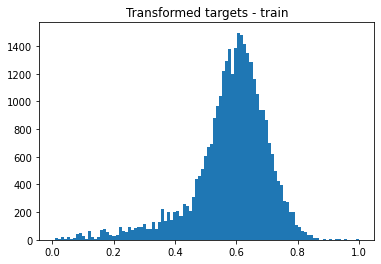

In [21]:
y_train_, y_test_ = np.array(y_), np.array(y_t)
y_train_, y_test_ = np.sum(y_train_, 1), np.sum(y_test_, 1)

#transform train targets
a = y_train_
idx_ = np.where(a!=0)
a[idx_]= np.log(-a[idx_])
y_train_ = a 

#transform test targets
a = y_test_
idx_ = np.where(a!=0)
a[idx_]= np.log(-a[idx_])
y_test_ = a

#normalize values
MAX_LOG_TARGET = np.max(y_train_)
y_train_ /= MAX_LOG_TARGET
y_test_ /= MAX_LOG_TARGET

see = y_train_
_ = plt.hist(see[see>0].reshape(-1,), 100)
plt.title('Transformed targets - train')

In [25]:
#one last check 
assert np.sum(np.isnan(X_train_)) == 0
assert np.sum(np.isnan(X_test_)) == 0
assert np.sum(np.isnan(y_train_)) == 0
assert np.sum(np.isnan(y_test_)) == 0

# **Model**

Regarding the stochastic nature of the problem, I thought that it is relevant to output upper and lower bounds on predictions. It is still possible to take the average (of the bounds) as a one point prediction. 

The chosen model is composed of several parts. 

**Architecture** : the model uses (multi-head) self-attention part in order to leverage dependencies between values at different timesteps. The output of this step is of a same dimension a its inputs. A residual connection is added at the end, so that, as the authors of ResNet say, "*if identity mappings are optimal, the solvers
may simply drive the weights of the multiple nonlinear layers toward zero to approach identity mappings [...] If the optimal function is closer to an identity
mapping than to a zero mapping, it should be easier for the
solver to find the perturbations with reference to an identity
mapping, than to learn the function as a new one*" (Deep Residual Learning for Image Recognition, Kaiming He & al.). 

Then, its outputs is simply flattened and transformed by several dense layers (multilayers perceptron).

We kept all default initialization values, except for the final layer biais which outputs two values (upper and lower bounds). These values are initialized using the 0.1 and 0.9 quantile of the train distribution (keeping 80% of the values in the range). This initialization appears to help a lot in the first stages of training.

**Loss**

The loss is the one presented in *High-Quality Prediction Intervals for Deep Learning:
A Distribution-Free, Ensembled Approach* (Algorithm 1).

It is composed of two parts : one that penalizes the Mean Prediction Interval Width and one that penalizes data coverage (which is active only when less than (1-alpha) % is covered (one-sided loss).
The idea : It is a minimization of the interval width under contraint of data coverage.

This loss has in addition to the alpha a lambda parameter, controlling
the importance of width vs. coverage.
The soften parameter allows for a smoother convergence (we use the default value in the paper). 
Finally, the n parameter, is the batch_size and should be large enough to justify the approximation of the binomial law by the normal distribution, as stated in the paper (the total number of captured points is modeled as a binomial output, approximated by a normal distribution. This result is used in the right-hand side of the loss, cf eq. 14 page 4).

**Other stuffs**
Dropout : we use dropout which is a regularization technique (dropouts weights randomly).
Optimizer : the chosen optimizer is the Adam optimizer. It is known for good empirical convergence properties on average, as it scales the learning rate during convergence (using running average of the second moment of the gradient) and uses momentum (running average of the first gradient moment) to stabilize the process.  
Layers Dimension : Dimension are chosen here to be quite small and basics. No further hyper parameter search has been done here. 
Callback : We use an early stop on test data. 

**Other approach**

It might be interesting here to test for an auto-regressive model (LSTM for example) in place or in conjunction with the present network architecture. Attention models are better at modelling one-to-one dependencies, and leveraging information over long-term structures. This might be particularly usefull if one sees the transactions as a long historical process without further reduction or sum-up (average over days, etc).



In [454]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

# hyperparameters
lambda_ = 0.01 # lambda in loss fn
alpha_ = 0.2  # capturing (1-alpha)% of samples
soften_ = 160.
n_ = 50 # batch size

# define loss fn
def qd_objective(y_true, y_pred):
    '''Loss_QD-soft, from algorithm 1'''
    y_true = y_true[:,0]
    y_u = y_pred[:,0]
    y_l = y_pred[:,1]
    
    K_HU = tf.maximum(0.,tf.sign(y_u - y_true))
    K_HL = tf.maximum(0.,tf.sign(y_true - y_l))
    K_H = tf.multiply(K_HU, K_HL)
    
    K_SU = tf.sigmoid(soften_ * (y_u - y_true))
    K_SL = tf.sigmoid(soften_ * (y_true - y_l))
    K_S = tf.multiply(K_SU, K_SL)
    
    MPIW_c = tf.reduce_sum(tf.multiply((y_u - y_l),K_H))/tf.reduce_sum(K_H+1e-5)
    PICP_H = tf.reduce_mean(K_H)
    PICP_S = tf.reduce_mean(K_S)
    
    Loss_S = MPIW_c + lambda_ * n_ / (alpha_*(1-alpha_)) * tf.maximum(0.,(1-alpha_) - PICP_S)**2
    
    return Loss_S
    
def transformer_encoder(inputs, head_size, num_heads, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs
    return res

def build_model(
    input_shape,
    head_size,
    num_heads,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, dropout)

    x = keras.layers.Flatten()(x)

    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    #output with initialized biais values
    outputs = layers.Dense(2, activation='linear',
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=1e-6),  
                bias_initializer=keras.initializers.Constant(value=[np.quantile(y_train_, 0.9),
                                                                    np.quantile(y_train_, 0.1)]))(x)
    
    return keras.Model(inputs, outputs)


model = build_model(
    (180,6),
    head_size=64,
    num_heads=4,
    dropout=0.5,
    mlp_dropout=0.5,
    num_transformer_blocks=2,
    mlp_units=[64, 64, 32])

opt = keras.optimizers.Adam(lr=1e-4)

model.compile(
    loss=qd_objective, 
    optimizer=opt)

model.summary()
callbacks = [keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)]

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 180, 6)]     0           []                               
                                                                                                  
 multi_head_attention_20 (Multi  (None, 180, 6)      6918        ['input_17[0][0]',               
 HeadAttention)                                                   'input_17[0][0]']               
                                                                                                  
 dropout_68 (Dropout)           (None, 180, 6)       0           ['multi_head_attention_20[0][0]']
                                                                                                  
 layer_normalization_20 (LayerN  (None, 180, 6)      12          ['dropout_68[0][0]']      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


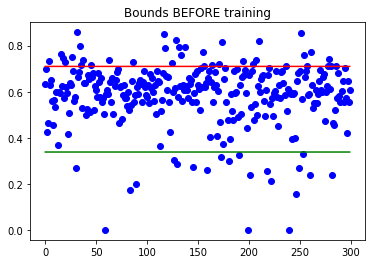

In [455]:
# plot and view some predictions
preds = model.predict(X_test_, batch_size=5)
y_pred = preds
y_u_pred = y_pred[:300,0]
y_l_pred = y_pred[:300,1]

plt.scatter(range(300), y_test_[:300], color='b')

plt.plot(y_u_pred, color='r') # upper boundary prediction
plt.plot(y_l_pred, color='g') # lower boundary prediction
plt.title('Bounds BEFORE training')
plt.show()

In [456]:
model.fit(
    X_train_,
    y_train_,
    validation_data=(X_test_, y_test_),
    epochs=500,
    batch_size=n_,
    callbacks=callbacks)

Epoch 1/500
695/695 [==============================] - 11s 14ms/step - loss: 0.2895 - val_loss: 0.3067
Epoch 2/500
695/695 [==============================] - 10s 14ms/step - loss: 0.2749 - val_loss: 0.2914
Epoch 3/500
695/695 [==============================] - 10s 14ms/step - loss: 0.2678 - val_loss: 0.2813
Epoch 4/500
695/695 [==============================] - 9s 13ms/step - loss: 0.2587 - val_loss: 0.2770
Epoch 5/500
695/695 [==============================] - 9s 13ms/step - loss: 0.2546 - val_loss: 0.2741
Epoch 6/500
695/695 [==============================] - 9s 13ms/step - loss: 0.2490 - val_loss: 0.2992
Epoch 7/500
695/695 [==============================] - 9s 13ms/step - loss: 0.2476 - val_loss: 0.2723
Epoch 8/500
695/695 [==============================] - 9s 13ms/step - loss: 0.2454 - val_loss: 0.2739
Epoch 9/500
695/695 [==============================] - 9s 13ms/step - loss: 0.2427 - val_loss: 0.2798
Epoch 10/500
695/695 [==============================] - 9s 13ms/step - loss: 0.

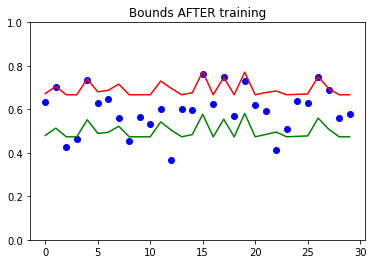

In [457]:
# plot and view some predictions
preds = model.predict(X_test_, batch_size=5)
y_pred = preds
y_u_pred = y_pred[:30,0]
y_l_pred = y_pred[:30,1]

plt.scatter(range(30), y_test_[:30], color='b')

plt.plot(y_u_pred, color='r') # upper boundary prediction
plt.plot(y_l_pred, color='g') # lower boundary prediction
plt.title('Bounds AFTER training')
plt.ylim(0,1)
plt.show()

In [458]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [459]:
model.save('/content/drive/MyDrive/mansa_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/vidfoot/mansa_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/vidfoot/mansa_model/assets


**Final thoughts**

The model overfits quickly. I anticipated that, but decided to keep going as it might be used with much more data in the future. Again, I think that several approaches could (should) be used to challenge this one, and several possibilities at different levels are possible (switch to a Tree model with more pre-computed features, use more historical data for each person, a larger and deeper network, etc). 

Last but not least, one could benchmark this approach with a simple baseline (outgoing of last 30 days for example). 